In [95]:
import pandas as pd
import numpy as np

In [96]:
preprocessed_df=pd.read_csv('Data/preprocessed_data.csv')
preprocessed_df.drop(['Unnamed: 0'],1,inplace=True)

In [97]:
preprocessed_df.head()

,Hostname,Application,Utilization(bps),Timestamp
0,vdevice-host-name,dns,105.000,2019-01-18 08:55:00
1,vdevice-host-name,tcp,0.000,2019-01-18 08:55:00
2,vdevice-host-name,https,2777.375,2019-01-18 08:55:00
3,vdevice-host-name,google_gen,0.000,2019-01-18 08:55:00
4,vdevice-host-name,firefox_update,0.000,2019-01-18 08:55:00


In [98]:
application_name=['dns','https']

In [99]:
# for i in application_name:
    
df=preprocessed_df.loc[preprocessed_df['Application'] == 'dns']
df=df[['Timestamp','Utilization(bps)']]
training_set=df[0:len(df)-3000]
print(training_set.shape)
training_set_sliced = training_set.iloc[:, 1:2].values


(13132, 2)


In [100]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set_sliced)


In [101]:
# Creating a data structure with 100 timesteps and 1 output
X_train = []
y_train = []
for i in range(120, len(training_set)):
    X_train.append(training_set_scaled[i-120:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [102]:

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

In [103]:

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 75, return_sequences = True, input_shape = (X_train.shape[1], 1)))
#rregressoregressor.add(Dropout(0.2))


# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 75))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')





In [104]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 120, 75)           23100     
_________________________________________________________________
lstm_18 (LSTM)               (None, 75)                45300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 76        
Total params: 68,476
Trainable params: 68,476
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
13012/13012 [==============================] - 104s 8ms/step - loss: 6.1791e-04
Epoch 2/100
13012/13012 [==============================] - 100s 8ms/step - loss: 5.7318e-04
Epoch 3/100
13012/13012 [==============================] - 53s 4ms/step - loss: 5.5904e-04
Epoch 4/100
13012/13012 [==============================] - 50s 4ms/step - loss: 5.5412e-04
Epoch 5/100
13012/13012 [==============================] - 56s 4ms/step - loss: 5.4875e-04
Epoch 6/100
13012/13012 [==============================] - 52s 4ms/step - loss: 5.4634e-04
Epoch 7/100
13012/13012 [==============================] - 52s 4ms/step - loss: 5.4619e-04
Epoch 8/100
13012/13012 [==============================] - 52s 4ms/step - loss: 5.4213e-04
Epoch 9/100
13012/13012 [==============================] - 53s 4ms/step - loss: 5.4089e-04
Epoch 10/100
13012/13012 [==============================] - 53s 4ms/step - loss: 5.3900e-04
Epoch 11/100
13012/13012 [==============================] - 56s 4ms/step - loss: 5.2673

In [106]:
print('model built successfully')
regressor.save('dns(100 epo- 75 neuron-120 time-rmsprop).h5') 

model built successfully


In [107]:

real_pattern_prediction=df[len(df)-3000:]

In [108]:
real_pattern_prediction.head()

,Timestamp,Utilization(bps)
440582,2019-03-05 00:30:00,499.875
440627,2019-03-05 00:35:00,825.750
440649,2019-03-05 00:40:00,479.125
440704,2019-03-05 00:45:00,552.375
440761,2019-03-05 00:50:00,642.500


In [109]:
training_set.head()

,Timestamp,Utilization(bps)
0,2019-01-18 08:55:00,105.0
9,2019-01-18 09:00:00,212.5
20,2019-01-18 09:05:00,105.0
21,2019-01-18 09:10:00,340.0
34,2019-01-18 09:15:00,142.5


In [110]:

# Getting the Random predictiond data
dataset_total = pd.concat((training_set['Utilization(bps)'], real_pattern_prediction['Utilization(bps)']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(real_pattern_prediction) - 120:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(120, len(real_pattern_prediction)+120):
    X_test.append(inputs[i-120:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_pattern = regressor.predict(X_test)
predicted_pattern = sc.inverse_transform(predicted_pattern)

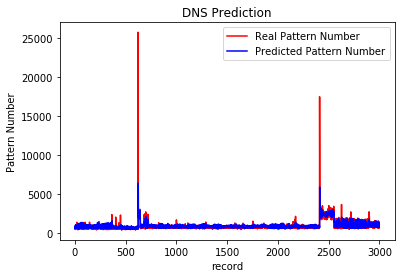

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
real_pattern_prediction=real_pattern_prediction.iloc[:, 1:2].values
# Visualising the results
plt.plot(real_pattern_prediction, color = 'red', label = 'Real Pattern Number')
plt.plot(predicted_pattern, color = 'blue', label = 'Predicted Pattern Number')
plt.title('DNS Prediction')
plt.xlabel('record')
plt.ylabel('Pattern Number')
plt.legend()
plt.show()